In [3]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras.models import *

input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [4]:
input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(400,400,1), name='input2')

conv_1 = Conv2D(30, (3, 3),padding='same')(input1)
conv_2 = Conv2D(30, (3, 3),padding='same')(input2)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

concat_1_2 = Dropout(0.5)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(3, 3),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

feature_3_5_7 = Dropout(0.5)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=30, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv_2, conv2])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv3, conv5])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)
conv6 = Dropout(0.5)(conv6)

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6)

model = Model([input1, input2], conv7)
    

#### Define PSNR Loss Metrics, remains loss function MSE ; Step Decay for Callbacks

In [5]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [6]:
def step_decay(epoch):
    initial_lrate = 0.0003
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

### Config Model

In [7]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
model.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNRLoss])
model.load_weights('small_weight.h5')

## Load data for testing

In [19]:
import spectral as spy

In [39]:
def addCloudMaskOverData(data, mask):
    maskedData = np.copy(data)
    maskedData[np.asarray(mask) != 0] = 0
    return maskedData

In [40]:
def readHDRFile(file_name, band):
    img = spy.open_image(file_name)
    data = img.read_band(band)
    return data

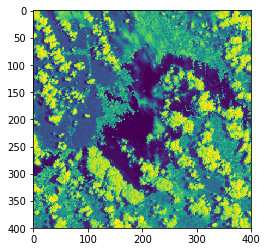

In [75]:
input1 = readHDRFile('manually_test/input_without_mask.hdr', 0)
plt.imshow(input1)

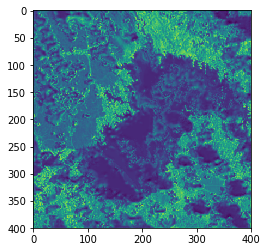

In [81]:
plt.imshow(output[0,:,:,0])

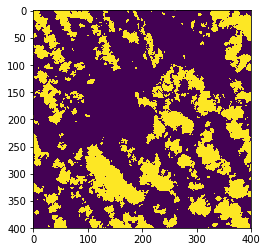

In [76]:
import cv2
mask = rasterio.open('TriAn_20130417_BQA.TIF','r').read(1)
mask = mask[:,186:186+1011]
mask = cv2.resize(mask, dsize=(400, 400))
plt.imshow(mask)

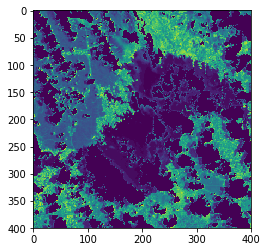

In [77]:
input1 = addCloudMaskOverData(input1, mask)
plt.imshow(input1)

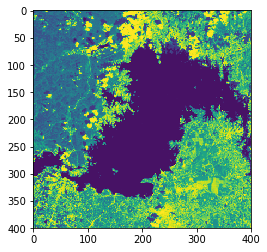

In [78]:
# Choose randomly
ref = readHDRFile('manually_test/ref/input_without_mask.hdr', 0)
plt.imshow(ref)

In [79]:
input1 = input1.reshape((1, 400, 400, 1))
ref = ref.reshape((1, 400, 400, 1))

In [80]:
output = model.predict([input1, ref])